In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections as collections 
import os

from collections import Counter    
from mlxtend.frequent_patterns import apriori, association_rules

import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

anime = pd.read_csv('anime_with_genre_separated.csv')
users = pd.read_csv('users_cleaned_with_location.csv')
anime_list = pd.read_csv('animelists_cleaned.csv')

In [2]:
anime_list.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [3]:
AL = anime_list.drop(['my_start_date','my_finish_date','my_status','my_rewatching','my_rewatching_ep','my_last_updated','my_tags'], axis=1)

In [4]:
AL = AL.dropna(axis=0)

In [5]:
AL

,username,anime_id,my_watched_episodes,my_score
0,karthiga,21,586,9
1,karthiga,59,26,7
2,karthiga,74,26,7
3,karthiga,120,26,7
4,karthiga,178,26,7
...,...,...,...,...
31284025,Yokonightcore,15611,48,9
31284026,Yokonightcore,27815,22,9
31284027,wargod,5945,39,8
31284028,JMc_SetoKai_LoVe,1316,52,9


In [6]:
AL.dtypes

username               object
anime_id                int64
my_watched_episodes     int64
my_score                int64
dtype: object

In [7]:
users = users.drop(['Unnamed: 0', 'access_rank','join_date','last_online','user_plantowatch'], axis=1)

In [8]:
import datetime as DT

now = pd.Timestamp('now')

users['birth_date'] = pd.to_datetime(users['birth_date'], format='%Y-%m-%d %H:%M:%S') 

users['birth_date'] = users['birth_date'].where(users['birth_date'] < now, users['birth_date'] -  np.timedelta64(100, 'Y')) 
users['age'] = (now - users['birth_date']).astype('<m8[Y]')    


In [9]:
users

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_days_spent_watching,gender,location,birth_date,stats_mean_score,stats_rewatched,stats_episodes,city,country,age
0,karthiga,2255153,3,49,1,0,55.091667,Female,"Chennai, India",1990-04-29,7.43,0.0,3391,NaN,india,30.0
1,Damonashu,37326,45,195,27,25,82.574306,Male,"Detroit,Michigan",1991-08-01,6.15,6.0,4903,detroit,united states,29.0
2,bskai,228342,25,414,2,5,159.483333,Male,"Nayarit, Mexico",1990-12-14,8.27,1.0,9701,NaN,mexico,29.0
3,terune_uzumaki,327311,5,5,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24,9.70,6.0,697,NaN,malaysia,22.0
4,Bas_G,5015094,35,114,6,20,30.458333,Male,"Nijmegen, Nederland",1999-10-24,7.86,0.0,1847,nederland,united states,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108706,isoann,797785,14,213,11,20,64.372222,Male,Poland:,1997-01-13,8.03,2.0,3939,NaN,NaN,23.0
108707,bumcakee,1396285,13,116,5,9,41.365972,Female,"nhollywood, california",1998-07-18,8.86,24.0,2537,california,united states,22.0
108708,Scarlet95,2478991,6,103,10,8,46.827083,Female,Belgium,1995-10-17,7.40,1.0,2869,NaN,belgium,25.0
108709,Torasori,3975907,22,239,0,4,72.361111,Male,"Latvia, Riga",1998-11-18,8.98,47.0,4469,NaN,latvia,22.0


In [10]:
for i in users.index:
    if users['age'][i] < 20:
        users.loc[i,'age_range'] = 'under20'
    elif users['age'][i] >= 20 and users['age'][i] < 25:
        users.loc[i,'age_range'] = '20-24'
    elif users['age'][i] >= 25 and users['age'][i] < 30:
        users.loc[i,'age_range'] = '25-29'
    elif users['age'][i] >= 30 and users['age'][i] < 35:
        users.loc[i,'age_range'] = '30-34'
    else:
        users.loc[i,'age_range'] = '35up'

In [11]:
user_AL_join = pd.merge(users, AL, on='username')

In [12]:
user_AL_join

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_days_spent_watching,gender,location,birth_date,stats_mean_score,stats_rewatched,stats_episodes,city,country,age,age_range,anime_id,my_watched_episodes,my_score
0,karthiga,2255153,3,49,1,0,55.091667,Female,"Chennai, India",1990-04-29,7.43,0.0,3391,NaN,india,30.0,30-34,21,586,9
1,karthiga,2255153,3,49,1,0,55.091667,Female,"Chennai, India",1990-04-29,7.43,0.0,3391,NaN,india,30.0,30-34,59,26,7
2,karthiga,2255153,3,49,1,0,55.091667,Female,"Chennai, India",1990-04-29,7.43,0.0,3391,NaN,india,30.0,30-34,74,26,7
3,karthiga,2255153,3,49,1,0,55.091667,Female,"Chennai, India",1990-04-29,7.43,0.0,3391,NaN,india,30.0,30-34,120,26,7
4,karthiga,2255153,3,49,1,0,55.091667,Female,"Chennai, India",1990-04-29,7.43,0.0,3391,NaN,india,30.0,30-34,178,26,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31283782,HMicca,1289601,11,73,2,2,64.431250,Female,"Birmingham, England",1995-08-12,8.89,11.0,3822,birmingham,united states,25.0,25-29,9441,13,9
31283783,HMicca,1289601,11,73,2,2,64.431250,Female,"Birmingham, England",1995-08-12,8.89,11.0,3822,birmingham,united states,25.0,25-29,12461,11,9
31283784,HMicca,1289601,11,73,2,2,64.431250,Female,"Birmingham, England",1995-08-12,8.89,11.0,3822,birmingham,united states,25.0,25-29,5671,25,7
31283785,HMicca,1289601,11,73,2,2,64.431250,Female,"Birmingham, England",1995-08-12,8.89,11.0,3822,birmingham,united states,25.0,25-29,521,52,8


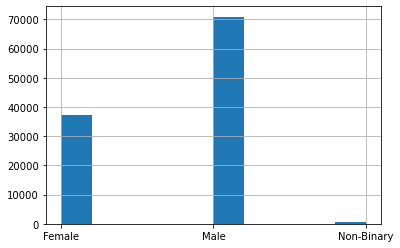

In [13]:
users['gender'].hist()

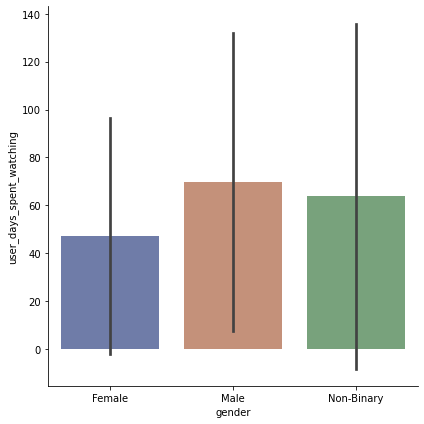

In [14]:
sns.catplot(
    data=users, kind="bar",
    x="gender", y="user_days_spent_watching",
    ci="sd", palette="dark", alpha=.6, height=6
)

#users['user_days_spent_watching'].hist(by=users['gender'])

In [15]:
user_AL_join.dtypes

username                            object
user_id                              int64
user_watching                        int64
user_completed                       int64
user_onhold                          int64
user_dropped                         int64
user_days_spent_watching           float64
gender                              object
location                            object
birth_date                  datetime64[ns]
stats_mean_score                   float64
stats_rewatched                    float64
stats_episodes                       int64
city                                object
country                             object
age                                float64
age_range                           object
anime_id                             int64
my_watched_episodes                  int64
my_score                             int64
dtype: object

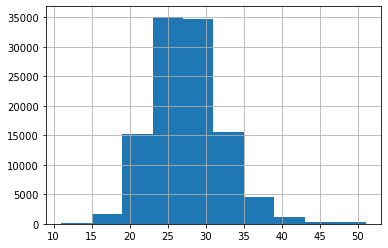

In [16]:
users['age'].hist()

In [17]:
#sns.relplot(x="age_range", y="anime_id", hue="gender", size="age_range",
#            sizes=(40, 400), alpha=.5, palette="muted",
#            height=6, data=user_AL_join)

In [18]:
anime

,Unnamed: 0,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,...,Demons,Game,Sci-Fi,Shounen,Seinen,Horror,Cars,Kids,Mystery,Mecha
0,0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,...,0,0,0,1,0,0,0,0,0,0
1,1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,...,0,0,0,1,0,0,0,0,0,0
2,2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,...,0,0,0,0,0,0,0,0,0,0
3,3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,...,0,0,0,0,0,0,0,0,0,0
4,4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,6663,37405,Dokidoki Little Ooyasan,NaN,dokidokiりとる大家さん,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Other,0,...,0,0,0,0,0,0,0,0,0,0
6664,6664,37886,Wo Shi Jiang Xiaobai (2018),I&#039;m Joybo OVA,我是江小白 小剧场,Wo Shi Jiang Xiao Bai: Xiao Ju Chang,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Original,1,...,0,0,0,0,0,0,0,0,0,0
6665,6665,37255,Genki Genki Non-tan: Obake Mura Meiro,NaN,げんきげんきノンタン おばけむらめいろ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Original,1,...,0,0,0,0,0,0,0,1,0,0
6666,6666,35229,Mr. Men Little Miss,Mr. Men Little Miss,Mr. Men Little Miss / ミスターメン リトルミス,NaN,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Picture book,0,...,0,0,0,0,0,0,0,1,0,0
